In [1]:
# =========================
# Core
# =========================
import numpy as np
import pandas as pd

# =========================
# Visualization
# =========================
import matplotlib.pyplot as plt
import seaborn as sns

# =========================
# Scikit-learn – preprocessing
# =========================
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

# =========================
# Scikit-learn – model selection
# =========================
from sklearn.model_selection import train_test_split

# =========================
# Scikit-learn – models
# =========================
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import fbeta_score

# =========================
# Scikit-learn – evaluation metrics
# =========================
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve)
from sklearn.metrics import precision_score, recall_score, average_precision_score
from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score)
from sklearn.decomposition import PCA


# =========================
# GPU (RAPIDS – optional)
# =========================
USE_GPU = True
try:
    import cudf
    from cuml.svm import SVC as cuSVC
    from cuml.metrics import roc_auc_score as cuml_roc_auc_score
except Exception as e:
    USE_GPU = False
    gpu_import_error = repr(e)

# טעינת הדאטה
file_path = r"C:\Users\hadar\Downloads\Traffic_Crashes_-_Crashes.csv"
df = pd.read_csv(file_path)

C:\Users\hadar\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\hadar\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# רשימת עמודות למחיקה
columns_to_drop = [
    'CRASH_RECORD_ID',
    'CRASH_DATE_EST_I',
    'LANE_CNT',
    'REPORT_TYPE',
    'INTERSECTION_RELATED_I',
    'NOT_RIGHT_OF_WAY_I',
    'HIT_AND_RUN_I',
    'DOORING_I',
    'PHOTOS_TAKEN_I',
    'STATEMENTS_TAKEN_I',
    'WORK_ZONE_I',
    'WORK_ZONE_TYPE',
    'WORKERS_PRESENT_I',
    'DATE_POLICE_NOTIFIED',
    'SEC_CONTRIBUTORY_CAUSE',
    'STREET_DIRECTION',
    'STREET_NO',
    'STREET_NAME',
    'BEAT_OF_OCCURRENCE',
    'INJURIES_TOTAL',
    'INJURIES_FATAL',
    'INJURIES_INCAPACITATING',
    'INJURIES_NON_INCAPACITATING',
    'INJURIES_REPORTED_NOT_EVIDENT',
    'INJURIES_NO_INDICATION',
    'INJURIES_UNKNOWN',
    'LOCATION',
    'LATITUDE',
    'LONGITUDE',
    'CRASH_TYPE'
]

# מחיקת העמודות
df = df.drop(columns=columns_to_drop)

In [3]:
# המרת עמודת התאריך לפורמט datetime
df['CRASH_DATE'] = pd.to_datetime(df['CRASH_DATE'])

# יצירת עמודת זמן (שעה בלבד)
df['CRASH_TIME'] = df['CRASH_DATE'].dt.time

# יצירת עמודת חודש
df['CRASH_MONTH'] = df['CRASH_DATE'].dt.month

# יצירת עמודת שנה
df['CRASH_YEAR'] = df['CRASH_DATE'].dt.year

# יצירת עמודת יום בשבוע
# pandas: Monday=0 ... Sunday=6
# אנחנו רוצים: Sunday=1 ... Saturday=7
df['CRASH_DAY_OF_WEEK'] = df['CRASH_DATE'].dt.weekday
df['CRASH_DAY_OF_WEEK'] = ((df['CRASH_DAY_OF_WEEK'] + 1) % 7) + 1
df = df[df['CRASH_YEAR'] == 2025].copy()
df = df.drop(columns=['CRASH_DATE','CRASH_YEAR'])

In [4]:
# אם CRASH_TIME הוא datetime.time / או מחרוזת - נהפוך אותו לטיפוס זמן אחיד
# (אם כבר אצלך הוא time, זה פשוט יעבוד)
crash_time = pd.to_datetime(df['CRASH_TIME'].astype(str), format='%H:%M:%S', errors='coerce')

# דקות מאז חצות (שומר דיוק: שעה+דקות+שניות)
df['CRASH_MINUTES_FROM_MIDNIGHT'] = crash_time.dt.hour * 60 + crash_time.dt.minute + (crash_time.dt.second / 60)

# IS_NIGHT: בין 20:00–06:00
# 20:00 = 1200 דקות, 06:00 = 360 דקות
df['IS_NIGHT'] = df['CRASH_MINUTES_FROM_MIDNIGHT'].apply(
    lambda m: 1 if (m >= 1200 or m < 360) else 0)

# IS_WEEKEND: יום ראשון (1) או שבת (7)
df['IS_WEEKEND'] = df['CRASH_DAY_OF_WEEK'].apply(lambda d: 1 if d in [1, 7] else 0)

# IS_RUSH_HOUR: 7–9 כולל ו־16–18 כולל
df['IS_RUSH_HOUR'] = df['CRASH_MINUTES_FROM_MIDNIGHT'].apply(
    lambda m: 1 if (420 <= m <= 540 or 960 <= m <= 1080) else 0)

df = df.drop(columns=['CRASH_MINUTES_FROM_MIDNIGHT'])

In [5]:
# המהירות החוקית הנמוכה ביותר בשיקגו היא 15 mph (סמטאות),
# לכן ערכים נמוכים מ-15 אינם מייצגים תמרור חוקי ונחשבים שגויים
df['POSTED_SPEED_LIMIT'] = pd.to_numeric(df['POSTED_SPEED_LIMIT'], errors='coerce')

# להשאיר רק שורות עם מהירות >= 15 או ערך חסר (NaN)
df = df[df['POSTED_SPEED_LIMIT'].isna() | (df['POSTED_SPEED_LIMIT'] >= 15)].copy()

In [6]:
col = 'TRAFFIC_CONTROL_DEVICE'
threshold = 5000

# 1) איחוד UNKNOWN ו-NaN ל-OTHER
df[col] = df[col].fillna('OTHER').replace('UNKNOWN', 'OTHER')

KEEP = {
    "NO CONTROLS",
    "TRAFFIC SIGNAL",
    "STOP SIGN/FLASHER"}
df = df[df["TRAFFIC_CONTROL_DEVICE"].isin(KEEP)].copy()

df = df[df[col] != 'OTHER'].copy()

In [7]:
col = 'DEVICE_CONDITION'

# ניקוי רווחים ויישור טקסט
df[col] = df[col].astype(str).str.strip()

# 1) איחוד UNKNOWN עם OTHER (וגם NaN אם יש)
df[col] = df[col].replace({'UNKNOWN': 'OTHER'}).fillna('OTHER')

# 2) איחוד קטגוריות "לא מתפקד" לקטגוריה אחת
df[col] = df[col].replace({
    'FUNCTIONING IMPROPERLY': 'NOT_FUNCTIONING',
    'NOT FUNCTIONING': 'NOT_FUNCTIONING',
    'WORN REFLECTIVE MATERIAL': 'NOT_FUNCTIONING',
    'MISSING': 'NOT_FUNCTIONING'
})

# 3) הסרת שורות עם OTHER (כולל UNKNOWN שאוחד)
df = df[df[col] != 'OTHER'].copy()

In [8]:
col = 'WEATHER_CONDITION'

# 1) ניקוי רווחים
df[col] = df[col].astype(str).str.strip()

# 2) הסרת UNKNOWN / OTHER / NaN
df[col] = df[col].replace(['UNKNOWN', 'OTHER'], 'UNKNOWN').fillna('UNKNOWN')
df = df[df[col] != 'UNKNOWN'].copy()

# 3) איחוד קטגוריות בתוך אותה עמודה
df.loc[df[col] == 'CLEAR', col] = 'Clear'
df.loc[df[col] == 'CLOUDY/OVERCAST', col] = 'Cloudy'
df.loc[df[col] == 'RAIN', col] = 'Rain'

df.loc[df[col].isin([
    'SNOW',
    'SLEET/HAIL',
    'FREEZING RAIN/DRIZZLE',
    'BLOWING SNOW'
]), col] = 'Snow/Ice'

df.loc[df[col].isin([
    'FOG/SMOKE/HAZE',
    'SEVERE CROSS WIND GATE',
    'BLOWING SAND, SOIL, DIRT'
]), col] = 'Low Visibility'

In [9]:
# ניקוי רווחים
df['LIGHTING_CONDITION'] = df['LIGHTING_CONDITION'].astype(str).str.strip()

# הסרת UNKNOWN
df = df[df['LIGHTING_CONDITION'] != 'UNKNOWN'].copy()

# איחוד קטגוריות: DAWN + DUSK -> TWILIGHT
df['LIGHTING_CONDITION'] = df['LIGHTING_CONDITION'].replace({
    'DAWN': 'TWILIGHT',
    'DUSK': 'TWILIGHT'})

In [10]:
df = df[~df['TRAFFICWAY_TYPE'].isin([
    'OTHER',
    'UNKNOWN',
    'NOT REPORTED',
    'UNKNOWN INTERSECTION TYPE'
])].copy()
df = df[~df['ROADWAY_SURFACE_COND'].isin(['OTHER', 'UNKNOWN'])].copy()

In [11]:
col = 'ROAD_DEFECT'

# 1) ניקוי רווחים
df[col] = df[col].astype(str).str.strip()

# 2) הסרת UNKNOWN ו-OTHER
df = df[~df[col].isin(['UNKNOWN', 'OTHER'])].copy()

# 3) המרה לבינארי:
# NO DEFECTS -> 0
# כל סוג פגם אחר -> 1
df[col] = df[col].apply(
    lambda x: 0 if x == 'NO DEFECTS' else 1).astype(int)

In [12]:
df = df[~df['PRIM_CONTRIBUTORY_CAUSE'].isin([
    'UNABLE TO DETERMINE',
    'NOT APPLICABLE'])].copy()

In [13]:
# יצירת משתנה יעד בינארי: פגיעה / ללא פגיעה
df['INJURY'] = df['MOST_SEVERE_INJURY'].apply(
    lambda x: 0 if x == 'NO INDICATION OF INJURY' else 1
).astype(int)

# (אופציונלי ומומלץ) הסרת עמודת המקור
df = df.drop(columns=['MOST_SEVERE_INJURY'])

In [14]:
# המרה ל-datetime אם צריך
df['CRASH_TIME'] = pd.to_datetime(df['CRASH_TIME'], format='%H:%M:%S')

# דקות מאז חצות
df['CRASH_MINUTES_FROM_MIDNIGHT'] = (
    df['CRASH_TIME'].dt.hour * 60 +
    df['CRASH_TIME'].dt.minute)
df = df.drop(columns=['CRASH_TIME'])

In [15]:
df['CRASH_TIME_SIN'] = np.sin(2 * np.pi * df['CRASH_MINUTES_FROM_MIDNIGHT'] / 1440)
df['CRASH_TIME_COS'] = np.cos(2 * np.pi * df['CRASH_MINUTES_FROM_MIDNIGHT'] / 1440)

In [16]:
# ------------------------------------------------------------
# 0) עזר: לנקות טקסטים בעמודות קטגוריות (מונע רווחים/None)
# ------------------------------------------------------------
cat_cols_for_rules = [
    'TRAFFIC_CONTROL_DEVICE',
    'LIGHTING_CONDITION',
    'WEATHER_CONDITION'
]

for c in cat_cols_for_rules:
    if c in df.columns:
        df[c] = df[c].astype(str).str.strip()

# ------------------------------------------------------------
# 1) NIGHT + NO TRAFFIC CONTROL
#    (IS_NIGHT = 1 וגם TRAFFIC_CONTROL_DEVICE == 'NO CONTROLS')
# ------------------------------------------------------------
df['NIGHT_AND_NO_CONTROL'] = (
    (df['IS_NIGHT'] == 1) &
    (df['TRAFFIC_CONTROL_DEVICE'].eq('NO CONTROLS'))
).astype(int)

# למה כדאי? בלילה בלי בקרה תנועתית יש פחות "הכוונה" → עלול להגדיל פגיעות.

# ------------------------------------------------------------
# 2) NIGHT + POOR LIGHTING
#    (לילה + DARKNESS)
# ------------------------------------------------------------
df['NIGHT_AND_POOR_LIGHTING'] = (
    (df['IS_NIGHT'] == 1) &
    (df['LIGHTING_CONDITION'].eq('DARKNESS'))
).astype(int)

# למה כדאי? שילוב חושך ותאורה לקויה מצמצם ראות וזמן תגובה.

# ------------------------------------------------------------
# 3) RUSH HOUR + NO TRAFFIC CONTROL
# ------------------------------------------------------------
df['RUSH_AND_NO_CONTROL'] = (
    (df['IS_RUSH_HOUR'] == 1) &
    (df['TRAFFIC_CONTROL_DEVICE'].eq('NO CONTROLS'))
).astype(int)

# למה כדאי? עומס תנועה ללא ויסות מעלה קונפליקטים וסיכון לתאונות.

# ------------------------------------------------------------
# 4) WEEKEND + NIGHT
# ------------------------------------------------------------
df['WEEKEND_NIGHT'] = (
    (df['IS_WEEKEND'] == 1) &
    (df['IS_NIGHT'] == 1)
).astype(int)

# למה כדאי? שעות בילוי/עייפות בסופ"ש בלילה קשורות לעיתים לסיכון מוגבר.

# ------------------------------------------------------------
# 5) MULTI_VEHICLE (יותר מרכב אחד)
# ------------------------------------------------------------
if 'NUM_UNITS' in df.columns:
    df['MULTI_VEHICLE_3PLUS'] = (df['NUM_UNITS'] >= 3).astype(int)

In [17]:
y = df['INJURY']
X = df.drop(columns=['INJURY'])

# Train (60%), Val (20%), Test (20%)
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=0.40, random_state=42, stratify=y)

X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.50, random_state=42, stratify=y_tmp)

# חשוב: לעבוד עם עותקים כדי לא לקבל בעיות SettingWithCopy
X_train = X_train.copy()
X_val   = X_val.copy()
X_test  = X_test.copy()

In [18]:
# =========================
# OHE (fit on TRAIN, transform on VAL/TEST)
# =========================
ohe_cols = [
    'TRAFFIC_CONTROL_DEVICE',
    'DEVICE_CONDITION',
    'WEATHER_CONDITION',
    'LIGHTING_CONDITION',
    'FIRST_CRASH_TYPE',
    'TRAFFICWAY_TYPE',
    'ALIGNMENT',
    'ROADWAY_SURFACE_COND',
    'DAMAGE',
    'PRIM_CONTRIBUTORY_CAUSE'
]

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

train_ohe = ohe.fit_transform(X_train[ohe_cols])
val_ohe   = ohe.transform(X_val[ohe_cols])
test_ohe  = ohe.transform(X_test[ohe_cols])

new_cols = ohe.get_feature_names_out(ohe_cols)

train_ohe_df = pd.DataFrame(train_ohe, columns=new_cols, index=X_train.index).astype(int)
val_ohe_df   = pd.DataFrame(val_ohe,   columns=new_cols, index=X_val.index).astype(int)
test_ohe_df  = pd.DataFrame(test_ohe,  columns=new_cols, index=X_test.index).astype(int)

X_train = pd.concat([X_train.drop(columns=ohe_cols), train_ohe_df], axis=1)
X_val   = pd.concat([X_val.drop(columns=ohe_cols),   val_ohe_df],   axis=1)
X_test  = pd.concat([X_test.drop(columns=ohe_cols),  test_ohe_df],  axis=1)

# =========================
# Scaling (fit on TRAIN, transform on VAL/TEST)
# =========================
num_cols = [
    'POSTED_SPEED_LIMIT',
    'NUM_UNITS',
    'CRASH_TIME_SIN',
    'CRASH_TIME_COS',
    'CRASH_MINUTES_FROM_MIDNIGHT'
]

scaler = StandardScaler()

X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_val[num_cols]   = scaler.transform(X_val[num_cols])
X_test[num_cols]  = scaler.transform(X_test[num_cols])

In [19]:
print(y.value_counts(normalize=True))

INJURY
0    0.790229
1    0.209771
Name: proportion, dtype: float64


In [20]:
# ============================================================
# Random Forest - Maximize F2 (tune on VAL, eval on TEST)
# ============================================================

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    min_samples_leaf=10,
    max_features="sqrt",
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

proba_val  = rf.predict_proba(X_val)[:, 1]
proba_test = rf.predict_proba(X_test)[:, 1]

beta = 2
prec, rec, thr = precision_recall_curve(y_val, proba_val)

best_f2 = -1
best_thr = None

for i in range(len(thr)):
    t = thr[i]
    y_pred_val = (proba_val >= t).astype(int)
    f2_val = fbeta_score(y_val, y_pred_val, beta=beta, zero_division=0)
    if f2_val > best_f2:
        best_f2 = f2_val
        best_thr = t

y_pred_test = (proba_test >= best_thr).astype(int)

y_pred_val_best = (proba_val >= best_thr).astype(int)

p_val  = precision_score(y_val, y_pred_val_best, zero_division=0)
r_val  = recall_score(y_val, y_pred_val_best, zero_division=0)
f2_val = fbeta_score(y_val, y_pred_val_best, beta=beta, zero_division=0)

p_test  = precision_score(y_test, y_pred_test, zero_division=0)
r_test  = recall_score(y_test, y_pred_test, zero_division=0)
f2_test = fbeta_score(y_test, y_pred_test, beta=beta, zero_division=0)

roc_auc_test = roc_auc_score(y_test, proba_test)
pr_auc_test  = average_precision_score(y_test, proba_test)

print("======================================================")
print("MODEL: Random Forest (Tune on VAL, eval on TEST)")
print(f"Rule: maximize F{beta} on VAL (no minimum recall constraint)")
print("======================================================")
print(f"Chosen threshold (from VAL): {best_thr:.6f}")
print(f"VAL  Precision: {p_val:.3f} | VAL  Recall: {r_val:.3f} | VAL  F{beta}: {f2_val:.3f}")
print(f"TEST Precision: {p_test:.3f} | TEST Recall: {r_test:.3f} | TEST F{beta}: {f2_test:.3f}")
print(f"ROC-AUC (TEST): {roc_auc_test:.4f}")
print(f"PR-AUC  (TEST): {pr_auc_test:.4f}\n")

print("Classification report (TEST):")
print(classification_report(y_test, y_pred_test, digits=3))

print("Confusion matrix (TEST):")
print(confusion_matrix(y_test, y_pred_test))

MODEL: Random Forest (Tune on VAL, eval on TEST)
Rule: maximize F2 on VAL (no minimum recall constraint)
Chosen threshold (from VAL): 0.418986
VAL  Precision: 0.321 | VAL  Recall: 0.848 | VAL  F2: 0.638
TEST Precision: 0.323 | TEST Recall: 0.848 | TEST F2: 0.640
ROC-AUC (TEST): 0.7883
PR-AUC  (TEST): 0.5581

Classification report (TEST):
              precision    recall  f1-score   support

           0      0.929     0.527     0.673      5729
           1      0.323     0.848     0.467      1521

    accuracy                          0.594      7250
   macro avg      0.626     0.688     0.570      7250
weighted avg      0.802     0.594     0.630      7250

Confusion matrix (TEST):
[[3020 2709]
 [ 231 1290]]


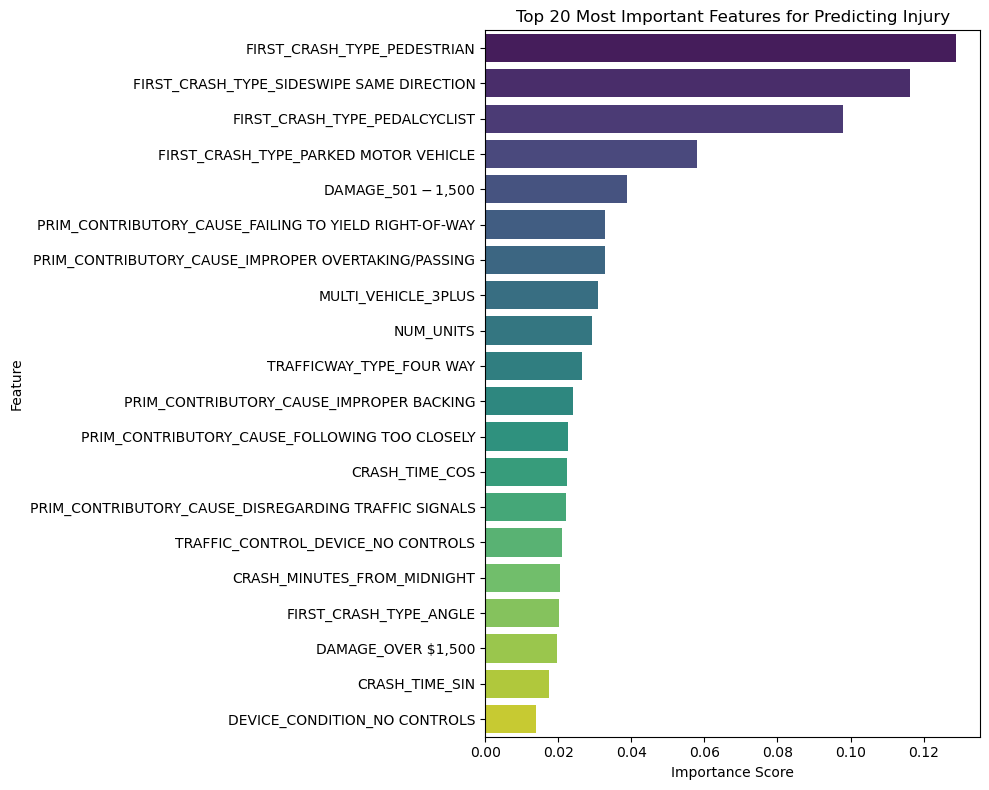

Bottom 10 features (potential for removal):
                                              Feature  Importance
57                     TRAFFICWAY_TYPE_L-INTERSECTION         0.0
87    PRIM_CONTRIBUTORY_CAUSE_DISREGARDING YIELD SIGN         0.0
84  PRIM_CONTRIBUTORY_CAUSE_DISREGARDING ROAD MARK...         0.0
82  PRIM_CONTRIBUTORY_CAUSE_CELL PHONE USE OTHER T...         0.0
81  PRIM_CONTRIBUTORY_CAUSE_BICYCLE ADVANCING LEGA...         0.0
25                   WEATHER_CONDITION_Low Visibility         0.0
62                         TRAFFICWAY_TYPE_ROUNDABOUT         0.0
74               ROADWAY_SURFACE_COND_SAND, MUD, DIRT         0.0
66                           ALIGNMENT_CURVE ON GRADE         0.0
38                        FIRST_CRASH_TYPE_OVERTURNED         0.0


In [21]:
# ============================================================
# Feature Importance - Analyzing which features impact 'INJURY'
# ============================================================

# 1. חילוץ חשיבות התכונות מהמודל שאימנו (rf)
importances = rf.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# 2. מיון התכונות לפי חשיבות מהגבוה לנמוך
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 3. הצגת 20 התכונות הכי משפיעות (כדי שהגרף יהיה קריא)
top_20_features = feature_importance_df.head(20)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=top_20_features, palette='viridis')
plt.title('Top 20 Most Important Features for Predicting Injury')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# 4. הדפסת התכונות עם החשיבות הנמוכה ביותר (אופציונלי - לבחירת תכונות להסרה)
print("Bottom 10 features (potential for removal):")
print(feature_importance_df.tail(10))

In [22]:
# הגדרת סף חשיבות (למשל, כל מה שתורם לפחות 0.5% למודל)
threshold = 0.005 
selected_features = feature_importance_df[feature_importance_df['Importance'] > threshold]['Feature'].tolist()

print(f"Number of features before: {len(X_train.columns)}")
print(f"Number of features after selection: {len(selected_features)}")

# עדכון הנתונים רק לתכונות הנבחרות
X_train = X_train[selected_features]
X_val = X_val[selected_features]
X_test = X_test[selected_features]

Number of features before: 116
Number of features after selection: 38


In [23]:
# ============================================================
# Random Forest - Maximize F2 (tune on VAL, eval on TEST)
# ============================================================

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    min_samples_leaf=10,
    max_features="sqrt",
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

proba_val  = rf.predict_proba(X_val)[:, 1]
proba_test = rf.predict_proba(X_test)[:, 1]

beta = 2
prec, rec, thr = precision_recall_curve(y_val, proba_val)

best_f2 = -1
best_thr = None

for i in range(len(thr)):
    t = thr[i]
    y_pred_val = (proba_val >= t).astype(int)
    f2_val = fbeta_score(y_val, y_pred_val, beta=beta, zero_division=0)
    if f2_val > best_f2:
        best_f2 = f2_val
        best_thr = t

y_pred_test = (proba_test >= best_thr).astype(int)

y_pred_val_best = (proba_val >= best_thr).astype(int)

p_val  = precision_score(y_val, y_pred_val_best, zero_division=0)
r_val  = recall_score(y_val, y_pred_val_best, zero_division=0)
f2_val = fbeta_score(y_val, y_pred_val_best, beta=beta, zero_division=0)

p_test  = precision_score(y_test, y_pred_test, zero_division=0)
r_test  = recall_score(y_test, y_pred_test, zero_division=0)
f2_test = fbeta_score(y_test, y_pred_test, beta=beta, zero_division=0)

roc_auc_test = roc_auc_score(y_test, proba_test)
pr_auc_test  = average_precision_score(y_test, proba_test)

print("======================================================")
print("MODEL: Random Forest (Tune on VAL, eval on TEST)")
print(f"Rule: maximize F{beta} on VAL (no minimum recall constraint)")
print("======================================================")
print(f"Chosen threshold (from VAL): {best_thr:.6f}")
print(f"VAL  Precision: {p_val:.3f} | VAL  Recall: {r_val:.3f} | VAL  F{beta}: {f2_val:.3f}")
print(f"TEST Precision: {p_test:.3f} | TEST Recall: {r_test:.3f} | TEST F{beta}: {f2_test:.3f}")
print(f"ROC-AUC (TEST): {roc_auc_test:.4f}")
print(f"PR-AUC  (TEST): {pr_auc_test:.4f}\n")

print("Classification report (TEST):")
print(classification_report(y_test, y_pred_test, digits=3))

print("Confusion matrix (TEST):")
print(confusion_matrix(y_test, y_pred_test))

MODEL: Random Forest (Tune on VAL, eval on TEST)
Rule: maximize F2 on VAL (no minimum recall constraint)
Chosen threshold (from VAL): 0.400572
VAL  Precision: 0.319 | VAL  Recall: 0.851 | VAL  F2: 0.638
TEST Precision: 0.320 | TEST Recall: 0.853 | TEST F2: 0.640
ROC-AUC (TEST): 0.7908
PR-AUC  (TEST): 0.5693

Classification report (TEST):
              precision    recall  f1-score   support

           0      0.930     0.519     0.667      5729
           1      0.320     0.853     0.466      1521

    accuracy                          0.589      7250
   macro avg      0.625     0.686     0.566      7250
weighted avg      0.802     0.589     0.624      7250

Confusion matrix (TEST):
[[2975 2754]
 [ 223 1298]]


In [24]:
# ============================================================
# Logistic Regression - Maximize F2 (threshold tuned on VAL)
# ============================================================

# 2) Train on TRAIN only
lr = LogisticRegression(max_iter=1000, class_weight="balanced")
lr.fit(X_train, y_train)

# 3) Predict probabilities for VAL and TEST
proba_val  = lr.predict_proba(X_val)[:, 1]
proba_test = lr.predict_proba(X_test)[:, 1]

# 4) Tune threshold on VALIDATION to maximize F2
beta = 2

prec, rec, thr = precision_recall_curve(y_val, proba_val)

# align arrays (thr shorter by 1)
prec_thr = prec[1:]
rec_thr  = rec[1:]

print("======================================================")
print("MODEL: Logistic Regression (Tune on VAL, eval on TEST)")
print(f"Rule: maximize F{beta} on VAL (no minimum recall constraint)")
print("======================================================")

best_f2 = -1
best_thr = None
best_idx = None

for i in range(len(thr)):
    t = thr[i]
    y_pred_val = (proba_val >= t).astype(int)
    f2_val = fbeta_score(y_val, y_pred_val, beta=beta, zero_division=0)
    if f2_val > best_f2:
        best_f2 = f2_val
        best_thr = t
        best_idx = i

# 5) Apply chosen threshold (from VAL) on TEST
y_pred_test = (proba_test >= best_thr).astype(int)

# 6) Report metrics on VAL (at chosen threshold) and TEST
y_pred_val_best = (proba_val >= best_thr).astype(int)

p_val  = precision_score(y_val, y_pred_val_best, zero_division=0)
r_val  = recall_score(y_val, y_pred_val_best, zero_division=0)
f2_val = fbeta_score(y_val, y_pred_val_best, beta=beta, zero_division=0)

p_test  = precision_score(y_test, y_pred_test, zero_division=0)
r_test  = recall_score(y_test, y_pred_test, zero_division=0)
f2_test = fbeta_score(y_test, y_pred_test, beta=beta, zero_division=0)

roc_auc_test = roc_auc_score(y_test, proba_test)
pr_auc_test  = average_precision_score(y_test, proba_test)

print(f"Chosen threshold (from VAL): {best_thr:.6f}")
print(f"VAL  Precision: {p_val:.3f} | VAL  Recall: {r_val:.3f} | VAL  F{beta}: {f2_val:.3f}")
print(f"TEST Precision: {p_test:.3f} | TEST Recall: {r_test:.3f} | TEST F{beta}: {f2_test:.3f}")
print(f"ROC-AUC (TEST): {roc_auc_test:.4f}")
print(f"PR-AUC  (TEST): {pr_auc_test:.4f}\n")

print("Classification report (TEST):")
print(classification_report(y_test, y_pred_test, digits=3))

print("Confusion matrix (TEST):")
print(confusion_matrix(y_test, y_pred_test))

MODEL: Logistic Regression (Tune on VAL, eval on TEST)
Rule: maximize F2 on VAL (no minimum recall constraint)
Chosen threshold (from VAL): 0.337914
VAL  Precision: 0.308 | VAL  Recall: 0.885 | VAL  F2: 0.643
TEST Precision: 0.309 | TEST Recall: 0.883 | TEST F2: 0.644
ROC-AUC (TEST): 0.7930
PR-AUC  (TEST): 0.5714

Classification report (TEST):
              precision    recall  f1-score   support

           0      0.939     0.477     0.632      5729
           1      0.309     0.883     0.458      1521

    accuracy                          0.562      7250
   macro avg      0.624     0.680     0.545      7250
weighted avg      0.807     0.562     0.596      7250

Confusion matrix (TEST):
[[2731 2998]
 [ 178 1343]]


In [25]:
# ============================================================
# SVM - Maximize F2 (tune on VAL, eval on TEST)  [GPU if available]
# ============================================================

def to_numpy(X):
    if hasattr(X, "to_numpy"):
        return X.to_numpy()
    return np.asarray(X)

USE_GPU = True
try:
    _ = cudf
    _ = cuSVC
    _ = cuml_roc_auc_score
except Exception as e:
    USE_GPU = False
    gpu_import_error = repr(e)

beta = 2

# -------------------------
# GPU path (cuML)
# -------------------------
if USE_GPU:

    def to_cudf(X):
        try:
            if sp.issparse(X):
                X = X.toarray()
        except Exception:
            pass
        if hasattr(X, "to_numpy"):
            return cudf.DataFrame.from_pandas(X)
        return cudf.DataFrame(X)

    def to_cudf_series(y):
        if hasattr(y, "to_numpy"):
            y = y.to_numpy()
        return cudf.Series(y)

    # Move to GPU (TRAIN/VAL/TEST)
    X_train_gpu = to_cudf(X_train)
    X_val_gpu   = to_cudf(X_val)
    X_test_gpu  = to_cudf(X_test)

    y_train_gpu = to_cudf_series(y_train)
    y_val_gpu   = to_cudf_series(y_val)
    y_test_gpu  = to_cudf_series(y_test)

    # Ensure float32
    for col in X_train_gpu.columns:
        if X_train_gpu[col].dtype == np.float64:
            X_train_gpu[col] = X_train_gpu[col].astype(np.float32)
            X_val_gpu[col]   = X_val_gpu[col].astype(np.float32)
            X_test_gpu[col]  = X_test_gpu[col].astype(np.float32)

    svm_gpu = cuSVC(
        kernel="rbf",
        C=1.0,
        gamma="scale",
        class_weight="balanced"
    )

    svm_gpu.fit(X_train_gpu, y_train_gpu)

    # scores (continuous) for VAL/TEST
    score_val_gpu  = svm_gpu.decision_function(X_val_gpu)
    score_test_gpu = svm_gpu.decision_function(X_test_gpu)

    # back to CPU numpy
    y_val_np   = y_val_gpu.to_numpy()
    y_test_np  = y_test_gpu.to_numpy()
    score_val  = score_val_gpu.to_numpy()
    score_test = score_test_gpu.to_numpy()

    # ---- Tune threshold on VAL to maximize F2 ----
    thresholds = np.unique(score_val)
    best_f2 = -1
    best_thr = None

    for t in thresholds:
        pred_val = (score_val >= t).astype(int)
        f2_val = fbeta_score(y_val_np, pred_val, beta=beta, zero_division=0)
        if f2_val > best_f2:
            best_f2 = f2_val
            best_thr = t

    # ---- Apply on TEST ----
    pred_test = (score_test >= best_thr).astype(int)

    # Metrics
    p_val  = precision_score(y_val_np,  (score_val >= best_thr).astype(int), zero_division=0)
    r_val  = recall_score(y_val_np,     (score_val >= best_thr).astype(int), zero_division=0)
    f2_val = fbeta_score(y_val_np,      (score_val >= best_thr).astype(int), beta=beta, zero_division=0)

    p_test  = precision_score(y_test_np, pred_test, zero_division=0)
    r_test  = recall_score(y_test_np,    pred_test, zero_division=0)
    f2_test = fbeta_score(y_test_np,     pred_test, beta=beta, zero_division=0)

    roc_auc_test = roc_auc_score(y_test_np, score_test)

    print("\n======================================================")
    print("MODEL: SVM (cuML / GPU)  (Tune on VAL, eval on TEST)")
    print(f"Rule: maximize F{beta} on VAL")
    print("======================================================")
    print(f"Chosen threshold (from VAL, on decision_function): {best_thr:.6f}")
    print(f"VAL  Precision: {p_val:.3f} | VAL  Recall: {r_val:.3f} | VAL  F{beta}: {f2_val:.3f}")
    print(f"TEST Precision: {p_test:.3f} | TEST Recall: {r_test:.3f} | TEST F{beta}: {f2_test:.3f}")
    print(f"ROC-AUC (TEST, score): {roc_auc_test:.4f}\n")

    print("Classification report (TEST):")
    print(classification_report(y_test_np, pred_test, digits=3))

    print("Confusion matrix (TEST):")
    print(confusion_matrix(y_test_np, pred_test))

# -------------------------
# CPU path (sklearn)
# -------------------------
else:
    print("\n==============================")
    print("SVM (sklearn / CPU) – GPU not available")
    print("==============================")
    print("Reason:", gpu_import_error)
    print("Tip: To use GPU you must install RAPIDS (cudf/cuml) with a CUDA-matching environment.\n")

    Xtr  = to_numpy(X_train).astype(np.float32, copy=False)
    Xva  = to_numpy(X_val).astype(np.float32, copy=False)
    Xte  = to_numpy(X_test).astype(np.float32, copy=False)
    ytr  = to_numpy(y_train)
    yva  = to_numpy(y_val)
    yte  = to_numpy(y_test)

    svm_cpu = SVC(
        kernel="rbf",
        C=1.0,
        gamma="scale",
        class_weight="balanced"
    )

    svm_cpu.fit(Xtr, ytr)

    # scores (continuous) for VAL/TEST
    score_val  = svm_cpu.decision_function(Xva)
    score_test = svm_cpu.decision_function(Xte)

    # ---- Tune threshold on VAL to maximize F2 ----
    thresholds = np.unique(score_val)
    best_f2 = -1
    best_thr = None

    for t in thresholds:
        pred_val = (score_val >= t).astype(int)
        f2_val = fbeta_score(yva, pred_val, beta=beta, zero_division=0)
        if f2_val > best_f2:
            best_f2 = f2_val
            best_thr = t

    # ---- Apply on TEST ----
    pred_test = (score_test >= best_thr).astype(int)

    # Metrics
    p_val  = precision_score(yva, (score_val >= best_thr).astype(int), zero_division=0)
    r_val  = recall_score(yva,    (score_val >= best_thr).astype(int), zero_division=0)
    f2_val = fbeta_score(yva,     (score_val >= best_thr).astype(int), beta=beta, zero_division=0)

    p_test  = precision_score(yte, pred_test, zero_division=0)
    r_test  = recall_score(yte,    pred_test, zero_division=0)
    f2_test = fbeta_score(yte,     pred_test, beta=beta, zero_division=0)

    roc_auc_test = roc_auc_score(yte, score_test)

    print("\n======================================================")
    print("MODEL: SVM (sklearn / CPU)  (Tune on VAL, eval on TEST)")
    print(f"Rule: maximize F{beta} on VAL")
    print("======================================================")
    print(f"Chosen threshold (from VAL, on decision_function): {best_thr:.6f}")
    print(f"VAL  Precision: {p_val:.3f} | VAL  Recall: {r_val:.3f} | VAL  F{beta}: {f2_val:.3f}")
    print(f"TEST Precision: {p_test:.3f} | TEST Recall: {r_test:.3f} | TEST F{beta}: {f2_test:.3f}")
    print(f"ROC-AUC (TEST, score): {roc_auc_test:.4f}\n")

    print("Classification report (TEST):")
    print(classification_report(yte, pred_test, digits=3))

    print("Confusion matrix (TEST):")
    print(confusion_matrix(yte, pred_test))


SVM (sklearn / CPU) – GPU not available
Reason: NameError("name 'cudf' is not defined")
Tip: To use GPU you must install RAPIDS (cudf/cuml) with a CUDA-matching environment.


MODEL: SVM (sklearn / CPU)  (Tune on VAL, eval on TEST)
Rule: maximize F2 on VAL
Chosen threshold (from VAL, on decision_function): -0.706994
VAL  Precision: 0.297 | VAL  Recall: 0.873 | VAL  F2: 0.629
TEST Precision: 0.298 | TEST Recall: 0.872 | TEST F2: 0.630
ROC-AUC (TEST, score): 0.7782

Classification report (TEST):
              precision    recall  f1-score   support

           0      0.931     0.456     0.612      5729
           1      0.298     0.872     0.445      1521

    accuracy                          0.543      7250
   macro avg      0.614     0.664     0.528      7250
weighted avg      0.798     0.543     0.577      7250

Confusion matrix (TEST):
[[2611 3118]
 [ 195 1326]]


In [26]:
# ============================================================
# Gradient Boosting - Maximize F2 (tune on VAL, eval on TEST)
# ============================================================

# 1) Build model
gb = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

# 2) Train on TRAIN only
gb.fit(X_train, y_train)

# 3) Predict probabilities for VAL and TEST
proba_val  = gb.predict_proba(X_val)[:, 1]
proba_test = gb.predict_proba(X_test)[:, 1]

# 4) Tune threshold on VALIDATION to maximize F2
beta = 2
prec, rec, thr = precision_recall_curve(y_val, proba_val)

best_f2 = -1
best_thr = None

for i in range(len(thr)):
    t = thr[i]
    y_pred_val = (proba_val >= t).astype(int)
    f2_val = fbeta_score(y_val, y_pred_val, beta=beta, zero_division=0)
    if f2_val > best_f2:
        best_f2 = f2_val
        best_thr = t

# 5) Apply chosen threshold (from VAL) on TEST
y_pred_test = (proba_test >= best_thr).astype(int)
y_pred_val_best = (proba_val >= best_thr).astype(int)

# 6) Metrics
p_val  = precision_score(y_val, y_pred_val_best, zero_division=0)
r_val  = recall_score(y_val, y_pred_val_best, zero_division=0)
f2_val = fbeta_score(y_val, y_pred_val_best, beta=beta, zero_division=0)

p_test  = precision_score(y_test, y_pred_test, zero_division=0)
r_test  = recall_score(y_test, y_pred_test, zero_division=0)
f2_test = fbeta_score(y_test, y_pred_test, beta=beta, zero_division=0)

roc_auc_test = roc_auc_score(y_test, proba_test)
pr_auc_test  = average_precision_score(y_test, proba_test)

print("======================================================")
print("MODEL: Gradient Boosting (Tune on VAL, eval on TEST)")
print(f"Rule: maximize F{beta} on VAL")
print("======================================================")
print(f"Chosen threshold (from VAL): {best_thr:.6f}")
print(f"VAL  Precision: {p_val:.3f} | VAL  Recall: {r_val:.3f} | VAL  F{beta}: {f2_val:.3f}")
print(f"TEST Precision: {p_test:.3f} | TEST Recall: {r_test:.3f} | TEST F{beta}: {f2_test:.3f}")
print(f"ROC-AUC (TEST): {roc_auc_test:.4f}")
print(f"PR-AUC  (TEST): {pr_auc_test:.4f}\n")

print("Classification report (TEST):")
print(classification_report(y_test, y_pred_test, digits=3))

print("Confusion matrix (TEST):")
print(confusion_matrix(y_test, y_pred_test))

MODEL: Gradient Boosting (Tune on VAL, eval on TEST)
Rule: maximize F2 on VAL
Chosen threshold (from VAL): 0.129522
VAL  Precision: 0.309 | VAL  Recall: 0.880 | VAL  F2: 0.642
TEST Precision: 0.309 | TEST Recall: 0.878 | TEST F2: 0.642
ROC-AUC (TEST): 0.7926
PR-AUC  (TEST): 0.5718

Classification report (TEST):
              precision    recall  f1-score   support

           0      0.937     0.478     0.633      5729
           1      0.309     0.878     0.457      1521

    accuracy                          0.562      7250
   macro avg      0.623     0.678     0.545      7250
weighted avg      0.805     0.562     0.596      7250

Confusion matrix (TEST):
[[2738 2991]
 [ 185 1336]]


In [27]:
# ============================================================
# KNN - Maximize F2 (tune on VAL, eval on TEST)
# ============================================================

# 1) Build model
knn = KNeighborsClassifier(
    n_neighbors=25,
    weights="distance",
    metric="minkowski"
)

# 2) Train on TRAIN only
knn.fit(X_train, y_train)

# 3) Predict probabilities for VAL and TEST
proba_val  = knn.predict_proba(X_val)[:, 1]
proba_test = knn.predict_proba(X_test)[:, 1]

# 4) Tune threshold on VALIDATION to maximize F2
beta = 2
prec, rec, thr = precision_recall_curve(y_val, proba_val)

best_f2 = -1
best_thr = None

for i in range(len(thr)):
    t = thr[i]
    y_pred_val = (proba_val >= t).astype(int)
    f2_val = fbeta_score(y_val, y_pred_val, beta=beta, zero_division=0)
    if f2_val > best_f2:
        best_f2 = f2_val
        best_thr = t

# 5) Apply chosen threshold (from VAL) on TEST
y_pred_test = (proba_test >= best_thr).astype(int)
y_pred_val_best = (proba_val >= best_thr).astype(int)

# 6) Metrics
p_val  = precision_score(y_val, y_pred_val_best, zero_division=0)
r_val  = recall_score(y_val, y_pred_val_best, zero_division=0)
f2_val = fbeta_score(y_val, y_pred_val_best, beta=beta, zero_division=0)

p_test  = precision_score(y_test, y_pred_test, zero_division=0)
r_test  = recall_score(y_test, y_pred_test, zero_division=0)
f2_test = fbeta_score(y_test, y_pred_test, beta=beta, zero_division=0)

roc_auc_test = roc_auc_score(y_test, proba_test)
pr_auc_test  = average_precision_score(y_test, proba_test)

print("======================================================")
print("MODEL: KNN (Tune on VAL, eval on TEST)")
print(f"Rule: maximize F{beta} on VAL")
print("======================================================")
print(f"Chosen threshold (from VAL): {best_thr:.6f}")
print(f"VAL  Precision: {p_val:.3f} | VAL  Recall: {r_val:.3f} | VAL  F{beta}: {f2_val:.3f}")
print(f"TEST Precision: {p_test:.3f} | TEST Recall: {r_test:.3f} | TEST F{beta}: {f2_test:.3f}")
print(f"ROC-AUC (TEST): {roc_auc_test:.4f}")
print(f"PR-AUC  (TEST): {pr_auc_test:.4f}\n")

print("Classification report (TEST):")
print(classification_report(y_test, y_pred_test, digits=3))

print("Confusion matrix (TEST):")
print(confusion_matrix(y_test, y_pred_test))

MODEL: KNN (Tune on VAL, eval on TEST)
Rule: maximize F2 on VAL
Chosen threshold (from VAL): 0.086316
VAL  Precision: 0.246 | VAL  Recall: 0.918 | VAL  F2: 0.593
TEST Precision: 0.246 | TEST Recall: 0.914 | TEST F2: 0.593
ROC-AUC (TEST): 0.6959
PR-AUC  (TEST): 0.3661

Classification report (TEST):
              precision    recall  f1-score   support

           0      0.919     0.258     0.403      5729
           1      0.246     0.914     0.388      1521

    accuracy                          0.396      7250
   macro avg      0.582     0.586     0.395      7250
weighted avg      0.778     0.396     0.400      7250

Confusion matrix (TEST):
[[1478 4251]
 [ 131 1390]]


In [28]:
df.to_csv("clean_data.csv", index=False)

In [29]:
X_for_cluster = X_train.copy()
y_for_profile = y_train.copy()

print("Shape for clustering:", X_for_cluster.shape)

Shape for clustering: (21749, 38)


In [30]:
n_nan = np.isnan(X_for_cluster.to_numpy()).sum()
n_inf = np.isinf(X_for_cluster.to_numpy()).sum()
print("NaN:", n_nan, "| Inf:", n_inf)

if n_nan > 0 or n_inf > 0:
    X_for_cluster = X_for_cluster.replace([np.inf, -np.inf], np.nan).fillna(0)
    print("Fixed NaN/Inf.")

NaN: 0 | Inf: 0


In [31]:
X_np = X_for_cluster.to_numpy()

k_values = range(2, 11)
inertias = []
sil_scores = []
ch_scores = []
db_scores = []

for k in k_values:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = km.fit_predict(X_np)

    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_np, labels))
    ch_scores.append(calinski_harabasz_score(X_np, labels))
    db_scores.append(davies_bouldin_score(X_np, labels))

results_k = pd.DataFrame({
    "k": list(k_values),
    "inertia": inertias,
    "silhouette": sil_scores,
    "calinski_harabasz": ch_scores,
    "davies_bouldin": db_scores
})

results_k

,k,inertia,silhouette,calinski_harabasz,davies_bouldin
0,2,627039.671641,0.354705,16644.763435,1.083160
1,3,516823.921229,0.233512,12415.445817,1.370898
2,4,453890.584863,0.217407,10429.166523,1.348024
3,5,393707.978825,0.223009,9848.069353,1.327973
4,6,351061.502555,0.221096,9363.386945,1.334001
5,7,326561.232885,0.209314,8659.698270,1.367915
6,8,311071.959927,0.186546,7946.492416,1.394761
7,9,295883.718385,0.175990,7449.251536,1.506311
8,10,285221.066864,0.173726,6959.083628,1.530965


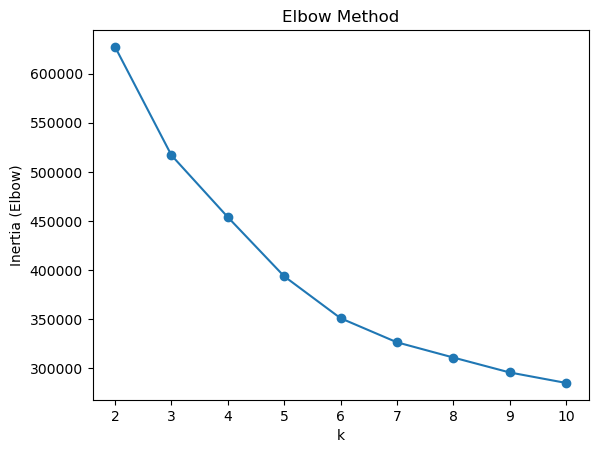

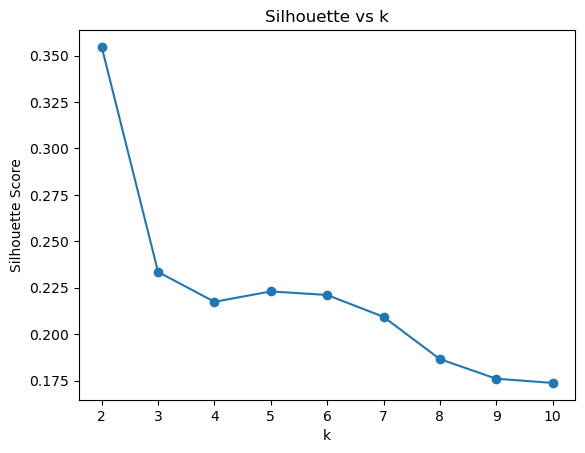

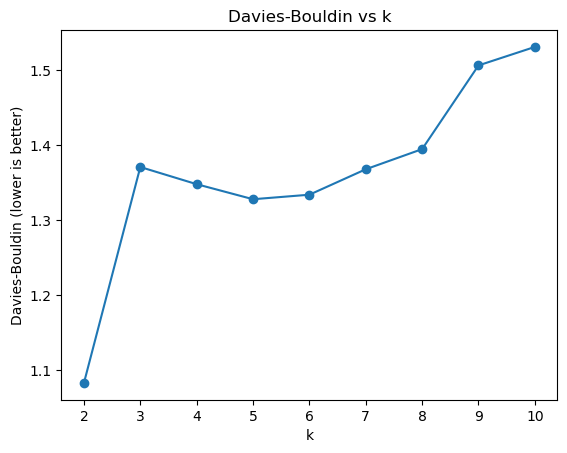

In [32]:
plt.figure()
plt.plot(results_k["k"], results_k["inertia"], marker="o")
plt.xlabel("k")
plt.ylabel("Inertia (Elbow)")
plt.title("Elbow Method")
plt.show()

plt.figure()
plt.plot(results_k["k"], results_k["silhouette"], marker="o")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.title("Silhouette vs k")
plt.show()

plt.figure()
plt.plot(results_k["k"], results_k["davies_bouldin"], marker="o")
plt.xlabel("k")
plt.ylabel("Davies-Bouldin (lower is better)")
plt.title("Davies-Bouldin vs k")
plt.show()

In [33]:
best_k = int(results_k.loc[results_k["silhouette"].idxmax(), "k"])
print("Best k by silhouette:", best_k)

Best k by silhouette: 2


In [34]:
final_kmeans = KMeans(n_clusters=best_k, n_init=20, random_state=42)
cluster_labels = final_kmeans.fit_predict(X_np)

clusters_df = X_for_cluster.copy()
clusters_df["cluster"] = cluster_labels

clusters_df["cluster"].value_counts().sort_index()

cluster
0    12571
1     9178
Name: count, dtype: int64

         POSTED_SPEED_LIMIT  NUM_UNITS
cluster                               
0                  0.021195   0.007788
1                 -0.029031  -0.010667


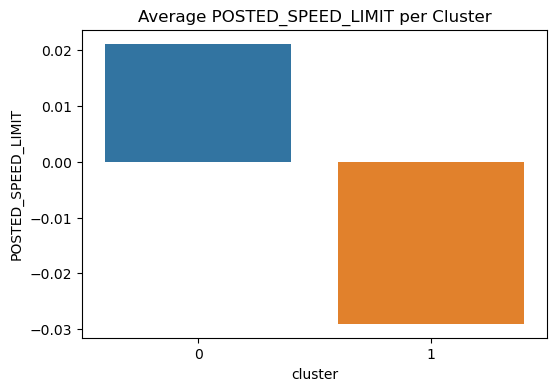

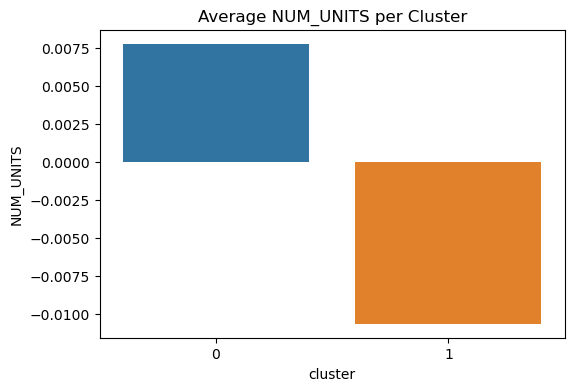

In [41]:
# הבנת המאפיינים של כל אשכול (Profiling)
# נבדוק את הממוצעים של התכונות המרכזיות בכל אשכול
# הערה: clusters_df הוא הדאטה שעליו הרצתן את הקלאסטרינג
cluster_profile = clusters_df.groupby('cluster').mean()

# נציג את ההבדלים במשתנים מרכזיים
important_cols = ['POSTED_SPEED_LIMIT', 'NUM_UNITS'] 
# אם יש עמודות נוספות כמו IS_NIGHT שהן בינאריות, הן יראו את אחוז המקרים
print(cluster_profile[important_cols])

# ויזואליזציה של ההבדלים בין האשכולות
for col in important_cols:
    plt.figure(figsize=(6, 4))
    sns.barplot(x=cluster_profile.index, y=cluster_profile[col])
    plt.title(f'Average {col} per Cluster')
    plt.show()

--- Real World Averages per Cluster ---
         POSTED_SPEED_LIMIT  NUM_UNITS  IS_NIGHT
cluster                                         
0                 29.440379   2.061093  0.208257
1                 29.238396   2.053280  0.204729


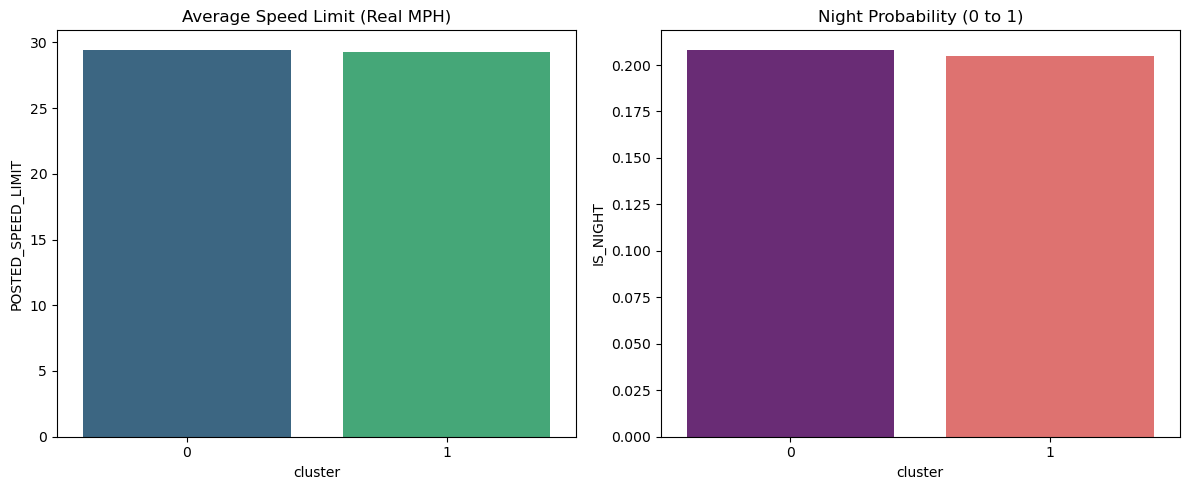

In [42]:
# 1. ניקח את הדאטה המקורי (לפני הסקיילר) ונשמור רק את השורות ששימשו לקלאסטרינג
# הערה: אם השתמשת ב-X_train לקלאסטרינג, נשתמש בגרסה הלא מנורמלת שלו
X_original = df.loc[X_train.index].copy()

# 2. נוסיף את תוצאות האשכולות
X_original['cluster'] = cluster_labels

# 3. עכשיו נחשב ממוצעים על הערכים האמיתיים!
comparison_real = X_original.groupby('cluster')[['POSTED_SPEED_LIMIT', 'NUM_UNITS', 'IS_NIGHT']].mean()

print("--- Real World Averages per Cluster ---")
print(comparison_real)

# 4. הצגת התוצאות בצורה גרפית ברורה
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.barplot(x=comparison_real.index, y=comparison_real['POSTED_SPEED_LIMIT'], ax=axes[0], palette='viridis')
axes[0].set_title('Average Speed Limit (Real MPH)')

sns.barplot(x=comparison_real.index, y=comparison_real['IS_NIGHT'], ax=axes[1], palette='magma')
axes[1].set_title('Night Probability (0 to 1)')

plt.tight_layout()
plt.show()

In [35]:
# יישור אינדקסים (כדי לא לקבל NaN בגלל index mismatch)
clusters_df = clusters_df.reset_index(drop=True)
y_for_profile = pd.Series(y_for_profile).reset_index(drop=True)

clusters_df["INJURY"] = y_for_profile.values

cluster_injury_rate = clusters_df.groupby("cluster")["INJURY"].agg(
    count="count",
    injury_rate="mean"
).sort_index()

cluster_injury_rate

,count,injury_rate
cluster,,
0,12571,0.213985
1,9178,0.203966


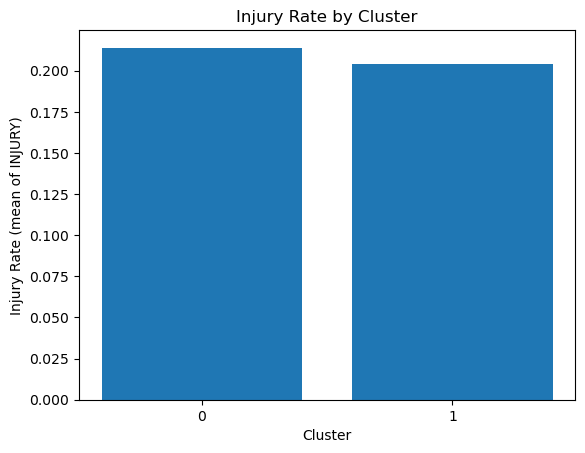

In [36]:
plt.figure()
plt.bar(cluster_injury_rate.index.astype(str), cluster_injury_rate["injury_rate"])
plt.xlabel("Cluster")
plt.ylabel("Injury Rate (mean of INJURY)")
plt.title("Injury Rate by Cluster")
plt.show()

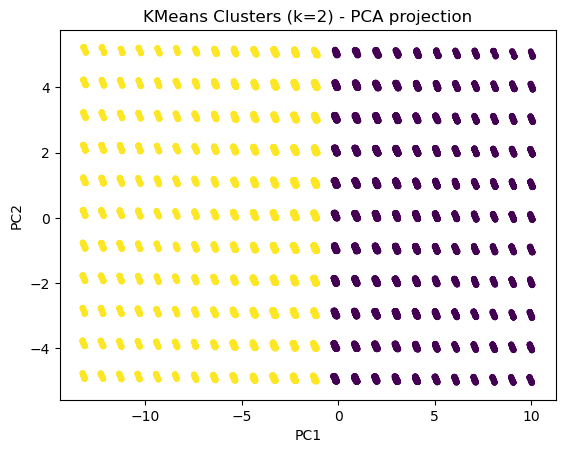

Explained variance ratio: [0.62418078 0.16877461]


In [37]:
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X_np)

plt.figure()
plt.scatter(X_2d[:, 0], X_2d[:, 1], s=10, c=cluster_labels)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"KMeans Clusters (k={best_k}) - PCA projection")
plt.show()

print("Explained variance ratio:", pca.explained_variance_ratio_)

In [38]:
final_metrics = {
    "k": best_k,
    "silhouette": float(silhouette_score(X_np, cluster_labels)),
    "calinski_harabasz": float(calinski_harabasz_score(X_np, cluster_labels)),
    "davies_bouldin": float(davies_bouldin_score(X_np, cluster_labels)),
    "inertia": float(final_kmeans.inertia_)
}

final_metrics

{'k': 2,
 'silhouette': 0.3547051164306709,
 'calinski_harabasz': 16644.7634347207,
 'davies_bouldin': 1.0831597037108478,
 'inertia': 627039.6716413198}

In [39]:
results_k.to_csv("kmeans_k_search_results.csv", index=False)
cluster_injury_rate.to_csv("cluster_injury_rate.csv")